In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import os
import pandas

In [19]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#对数据做归一化（-1 --- 1）
transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize(0.5,0.5),
    ]
)
 
#train_ds = torchvision.datasets.MNIST("dataset",train = True,transform = tranform,download=True)
train_ds = torchvision.datasets.MNIST('dataset',transform=transform)
dataloader = torch.utils.data.DataLoader(train_ds,batch_size = 20,shuffle = True)
 
imgs, _ =next(iter(dataloader))
print(imgs.shape)  #torch.Size([64, 1, 28, 28])
 
# batch_size=64 图片大小：1,28,28
# 定义生成器
# 输入是长度为100的噪声（正态分布随机数）
# 输出为（1,28,28）的图片
 
# linear1:100---256
# linear2:256---512
# linear1:512---28*28
# linear2:28*28---(1,28,28)
 

torch.Size([20, 1, 28, 28])


In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(1,10,kernel_size=5,padding=2),
            nn.BatchNorm2d(10),#标准化
            nn.ReLU(),#激活函数  
        )
        self.layer1 = nn.Sequential(
            nn.Conv2d(10,12,kernel_size=3,padding=1),
            nn.BatchNorm2d(12),#标准化
            nn.ReLU(),#激活函数
            nn.MaxPool2d(kernel_size=2)#最大池化，池化后尺寸缩半,m*14*14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(12,25,kernel_size=1),
            nn.BatchNorm2d(25),#标准化
            nn.ReLU(),
            nn.Conv2d(25,25,kernel_size=1),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(25,15,kernel_size=1),
            nn.BatchNorm2d(15),#标准化
            nn.ReLU(),
            nn.Conv2d(15,5,kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(5,1,kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
    def forward(self,x):  # x表示长度为100的噪声输入
        img = self.layer0(x)
        img = self.layer1(img)
        img = self.layer2(img)
        img = self.layer3(img)
        return img
 
# 定义判别器
# 输入为（1,28,28）的图片，输出为二分类的概率值，输出使用sigmoid激活
# BCELose计算交叉熵损失
# nn.LeakyReLU  f(x):x>0,输出x，如果x<0,输出a*x，a表示一个很小的斜率，比如0.1
#判别器中一般推荐使用nn.LeakyReLU
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,10,kernel_size=5,padding=2),
            nn.BatchNorm2d(10),#标准化
            nn.ReLU(),#激活函数
            nn.MaxPool2d(kernel_size=2)#最大池化，池化后尺寸缩半,m*14*14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(10,20,kernel_size=3,padding=1),
            nn.BatchNorm2d(20),#标准化
            nn.ReLU(),#激活函数
            nn.MaxPool2d(kernel_size=2)#最大池化，池化后尺寸缩半,m*14*14
        )
        self.main = nn.Sequential(
            nn.Linear(7*7,25),
            nn.LeakyReLU(),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )
 
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1,7*7)
        x = self.main(x)
        return x
 

Epoch 0
Epoch 1
Epoch 2
Epoch 3


KeyboardInterrupt: 

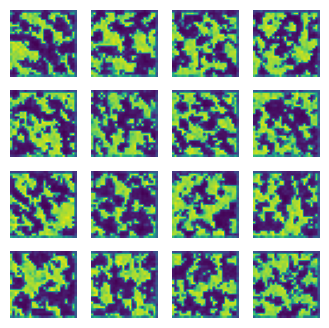

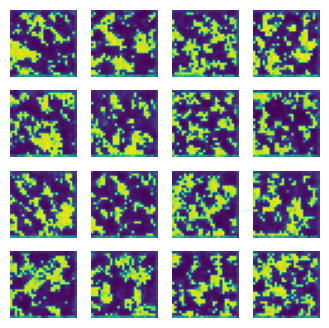

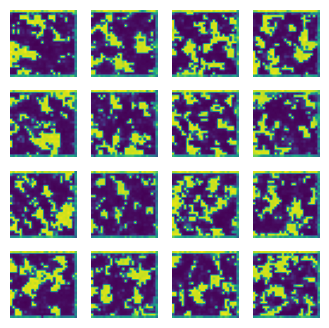

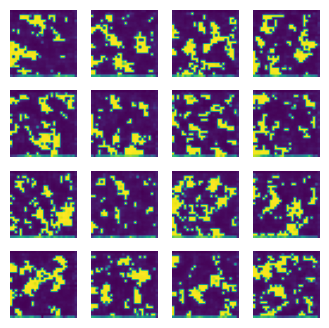

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cuda' if 0 else 'cpu'
gen = Generator().to(device)
dis = Discriminator().to(device)
d_optim = torch.optim.Adam(dis.parameters(),lr=0.0001)
g_optim = torch.optim.Adam(gen.parameters(),lr=0.0001)
 
loss_fn = torch.nn.BCELoss()
 
def gen_img_plot(model,test_input):
    predictions = np.squeeze(model(test_input).detach().cpu().numpy())
# detach()截断梯度,np.squeeze可以去掉维度为1
    fig = plt.figure(figsize=(4,4))
    for i in range(16):  # prediction.size(0)=16
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i]) # tanh 得到的是-1 - 1之间，-》0-1之间
        plt.axis("off")
 
test_input = torch.randn(16,1,56,56,device=device)  # 16个长度为100的正态随机数
 
# print(test_input)
 
D_loss = []
G_loss = []
 
# 训练循环
for epoch in range(50):
    d_epoch_loss = 0
    g_epoch_loss = 0
    count = len(dataloader)  # len(dataloader)返回批次数
                             # len(dataset)返回样本数
    for step,(img,_) in enumerate(dataloader):
        img = img.to(device)
        size = img.size(0)
        
        random_noise = torch.randn(size,1,56,56,device=device)
        #print(random_noise.shape)
        d_optim.zero_grad()
        real_output = dis(img)  # 对判别器输入真实图片 real_output对真实图片的预测结果
        #得到判别器在真实图像上面的损失
        d_real_loss = loss_fn(real_output,torch.ones_like(real_output))
 
        d_real_loss.backward()
 
        gen_img = gen(random_noise)
        #detach()截断生成器梯度，更新判别器梯度
        fake_output = dis(gen_img.detach())  # 判别器输入生成图片。fake_output对生成图片的预测
        # 得到判别器在生成图像上面的损失
        d_fake_loss = loss_fn(fake_output,torch.zeros_like(fake_output))
 
        d_fake_loss.backward()
 
        d_loss = d_fake_loss + d_real_loss
        d_optim.step()
 
        g_optim.zero_grad()
        fake_output = dis(gen_img)
        # 得到生成器的损失
        g_loss = loss_fn(fake_output,torch.ones_like(fake_output))
 
        g_loss.backward()
        g_optim.step()
 
        with torch.no_grad():
            d_epoch_loss +=d_loss
            g_epoch_loss +=g_loss
 
    with torch.no_grad():
        d_epoch_loss /=count
        g_epoch_loss /=count
        D_loss.append(d_epoch_loss)
        G_loss.append(g_epoch_loss)
        print("Epoch",epoch)
 
        gen_img_plot(gen,test_input)

In [36]:
import cv2
img=cv2.imread("Baidu/cat1/1cat.jpg")

255


(<Axes: >, [<matplotlib.lines.Line2D at 0x19ee70f8ee0>])

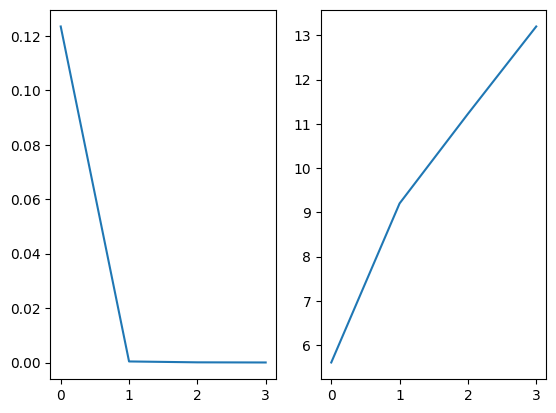

In [28]:
plt.subplot(1,2,1),plt.plot(np.array(torch.tensor(D_loss).to('cpu')))
plt.subplot(1,2,2),plt.plot( np.array(torch.tensor(G_loss).to('cpu')))

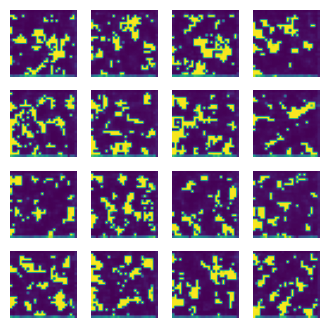

In [30]:
def gen_img_plot(model,test_input):
    predictions = np.squeeze(model(test_input).detach().cpu().numpy())
# detach()截断梯度,np.squeeze可以去掉维度为1
    fig = plt.figure(figsize=(4,4))
    for i in range(16):  # prediction.size(0)=16
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i]) # tanh 得到的是-1 - 1之间，-》0-1之间
        plt.axis("off")
    plt.show()
gen_img_plot(gen,torch.randn(16,1,56,56,device=device))